# **Data Preparation**

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import os
import pathlib
from matplotlib import pyplot as plt
import seaborn as sns
import pickle
import pandas as pd
import numpy as np
import cv2
import skimage
from skimage.util import random_noise
import tensorflow as tf

from tqdm.notebook import tqdm
import random

C:\Users\Mira\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\Mira\anaconda3\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
C:\Users\Mira\anaconda3\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [34]:
# Pre-trained model link - https://github.com/chintan1995/Image-Denoising-using-Deep-Learning

# **PRIDNet**
<a href='https://arxiv.org/pdf/1908.00273.pdf'>https://arxiv.org/pdf/1908.00273.pdf</a>


In [2]:
import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, Conv2DTranspose,\
                                    GlobalAveragePooling2D, AveragePooling2D, MaxPool2D, UpSampling2D,\
                                    BatchNormalization, Activation, Flatten, Dense, Input,\
                                    Add, Multiply, Concatenate, concatenate, Softmax
from tensorflow.keras import initializers, regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.activations import softmax

tf.keras.backend.set_image_data_format('channels_last')

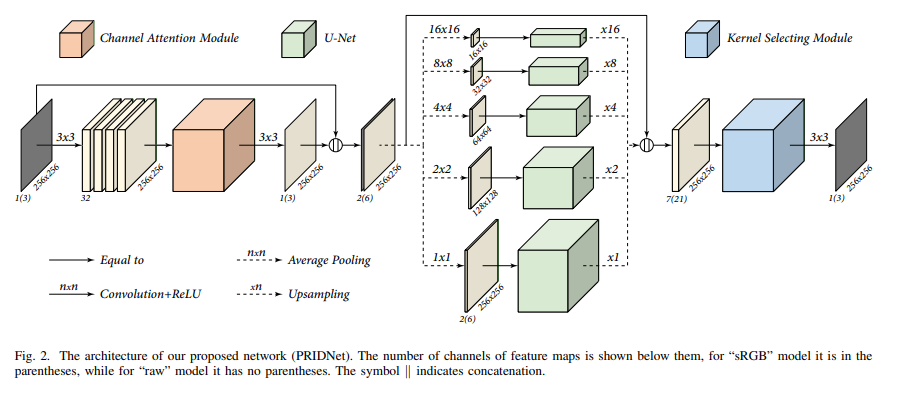

In [3]:
class Convolutional_block(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.conv_1 = Conv2D(filters=64, kernel_size=(3,3), strides=1, padding='same')
        self.conv_2 = Conv2D(filters=64, kernel_size=(3,3), strides=1, padding='same')
        self.conv_3 = Conv2D(filters=64, kernel_size=(3,3), strides=1, padding='same')
        self.conv_4 = Conv2D(filters=64, kernel_size=(3,3), strides=1, padding='same')

    def call(self, X):
        X_1 = self.conv_1(X)
        X_1 = Activation('relu')(X_1)

        X_2 = self.conv_2(X_1)
        X_2 = Activation('relu')(X_2)

        X_3 = self.conv_3(X_2)
        X_3 = Activation('relu')(X_3)

        X_4 = self.conv_4(X_3)
        X_4 = Activation('relu')(X_4)
        
        #print('---conv block=',X_4.shape)
        
        return X_4

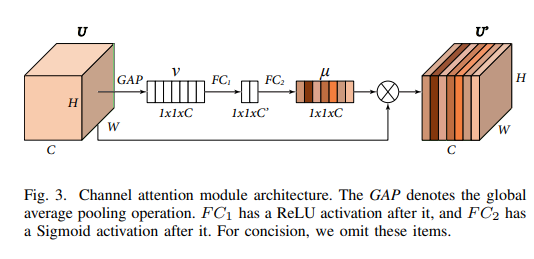

In [4]:
class Channel_attention(tf.keras.layers.Layer):
    def __init__(self, C=64, **kwargs):
        super().__init__(**kwargs)
        self.C=C
        self.gap = GlobalAveragePooling2D()
        self.dense_middle = Dense(units=2, activation='relu')
        self.dense_sigmoid = Dense(units=self.C, activation='sigmoid')
    
    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'C': self.C
        })
        return config

    def call(self, X):
        v = self.gap(X)
        #print("ca_ after gap =",v.shape)
        fc1 = self.dense_middle(v)
        #print("ca_ after fc1 =",fc1.shape)
        mu = self.dense_sigmoid(fc1)
        #print("ca_ after fc2 =",mu.shape)

        U_out = Multiply()([X, mu])
        
        #print('---channel attention block=',U_out.shape)

        return U_out

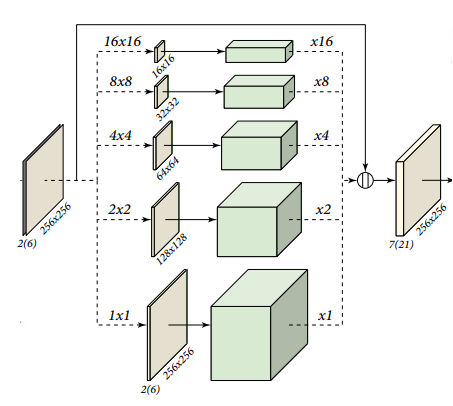

In [5]:
class Avg_pool_Unet_Upsample_msfe(tf.keras.layers.Layer):
    def __init__(self, avg_pool_size, upsample_rate, **kwargs):
        super().__init__(**kwargs)
        # ---initialization for Avg pooling---
        self.avg_pool = AveragePooling2D(pool_size=avg_pool_size, padding='same')

        # --- initialization for Unet---
        self.deconv_lst = []
        filter=512
        for i in range(4):
            self.deconv_lst.append(Conv2DTranspose(filters=filter/2, kernel_size=[3, 3], strides=2, padding='same'))
            filter/=2

        self.conv_32_down_lst = []
        for i in range(4):
            self.conv_32_down_lst.append(Conv2D(filters=64, kernel_size=[3, 3], activation='relu', padding='same', kernel_regularizer=regularizers.l2(l2=0.001)))

        self.conv_64_down_lst = []
        for i in range(4):
            self.conv_64_down_lst.append(Conv2D(filters=128, kernel_size=[3, 3], activation='relu', padding='same', kernel_regularizer=regularizers.l2(l2=0.001)))

        self.conv_128_down_lst = []
        for i in range(4):
            self.conv_128_down_lst.append(Conv2D(filters=256, kernel_size=[3, 3], activation='relu', padding='same', kernel_regularizer=regularizers.l2(l2=0.001)))

        self.conv_256_down_lst = []
        for i in range(4):
            self.conv_256_down_lst.append(Conv2D(filters=512, kernel_size=[3, 3], activation='relu', padding='same', kernel_regularizer=regularizers.l2(l2=0.001)))

        self.conv_512_down_lst = []
        for i in range(4):
            self.conv_512_down_lst.append(Conv2D(filters=1024, kernel_size=[3, 3], activation='relu', padding='same', kernel_regularizer=regularizers.l2(l2=0.001)))


        self.conv_32_up_lst = []
        for i in range(3):
            self.conv_32_up_lst.append(Conv2D(filters=64, kernel_size=[3, 3], activation='relu', padding='same', kernel_regularizer=regularizers.l2(l2=0.001)))

        self.conv_64_up_lst = []
        for i in range(3):
            self.conv_64_up_lst.append(Conv2D(filters=128, kernel_size=[3, 3], activation='relu', padding='same', kernel_regularizer=regularizers.l2(l2=0.001)))

        self.conv_128_up_lst = []
        for i in range(3):
            self.conv_128_up_lst.append(Conv2D(filters=256, kernel_size=[3, 3], activation='relu', padding='same', kernel_regularizer=regularizers.l2(l2=0.001)))

        self.conv_256_up_lst = []
        for i in range(3):
            self.conv_256_up_lst.append(Conv2D(filters=512, kernel_size=[3, 3], activation='relu', padding='same', kernel_regularizer=regularizers.l2(l2=0.001)))


        self.conv_3 = Conv2D(filters=3, kernel_size=[1, 1])

        self.pooling1_unet = MaxPool2D(pool_size=[2, 2], padding='same')
        self.pooling2_unet = MaxPool2D(pool_size=[2, 2], padding='same')
        self.pooling3_unet = MaxPool2D(pool_size=[2, 2], padding='same')
        self.pooling4_unet = MaxPool2D(pool_size=[2, 2], padding='same')

        # ---initialization for Upsampling---
        self.upsample = UpSampling2D(upsample_rate, interpolation='bilinear')
    
    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'avg_pool_size': self.avg_pool_size,
            'upsample_rate':self.upsample_rate
        })
        return config

    def upsample_and_concat(self, x1, x2, i):
        deconv = self.deconv_lst[i](x1)
        deconv_output = Concatenate()([deconv, x2])
        return deconv_output

    def unet(self, input):
        # ---Unet downsampling---
        conv1 = input
        for c_32 in self.conv_32_down_lst:
            conv1 = c_32(conv1)
        pool1 = self.pooling1_unet(conv1)

        conv2 = pool1
        for c_64 in self.conv_64_down_lst:
            conv2 = c_64(conv2)
        pool2 = self.pooling2_unet(conv2)

        conv3 = pool2
        for c_128 in self.conv_128_down_lst:
            conv3 = c_128(conv3)
        pool3 = self.pooling3_unet(conv3)

        conv4 = pool3
        for c_256 in self.conv_256_down_lst:
            conv4 = c_256(conv4)
        pool4 = self.pooling4_unet(conv4)

        conv5 = pool4
        for c_512 in self.conv_512_down_lst:
            conv5 = c_512(conv5)

        # ---Unet upsampling---
        up6 = self.upsample_and_concat(conv5, conv4, 0)
        conv6 = up6
        for c_256 in self.conv_256_up_lst:
            conv6 = c_256(conv6)

        up7 = self.upsample_and_concat(conv6, conv3, 1)
        conv7 = up7
        for c_128 in self.conv_128_up_lst:
            conv7 = c_128(conv7)

        up8 = self.upsample_and_concat(conv7, conv2, 2)
        conv8 = up8
        for c_64 in self.conv_64_up_lst:
            conv8 = c_64(conv8)

        up9 = self.upsample_and_concat(conv8, conv1, 3)
        conv9 = up9
        for c_32 in self.conv_32_up_lst:
            conv9 = c_32(conv9)

        conv10 = self.conv_3(conv9)
        return conv10

    def call(self, X):
        avg_pool = self.avg_pool(X)
        #print("ap =",avg_pool.shape)
        unet = self.unet(avg_pool)
        upsample = self.upsample(unet)
        return upsample

In [6]:
class Multi_scale_feature_extraction(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.msfe_16 = Avg_pool_Unet_Upsample_msfe(avg_pool_size=16, upsample_rate=16)
        self.msfe_8 = Avg_pool_Unet_Upsample_msfe(avg_pool_size=8, upsample_rate=8)
        self.msfe_4 = Avg_pool_Unet_Upsample_msfe(avg_pool_size=4, upsample_rate=4)
        self.msfe_2 = Avg_pool_Unet_Upsample_msfe(avg_pool_size=2, upsample_rate=2)
        self.msfe_1 = Avg_pool_Unet_Upsample_msfe(avg_pool_size=1, upsample_rate=1)

    def call(self, X):
        up_sample_16 = self.msfe_16(X)
        up_sample_8 = self.msfe_8(X)
        up_sample_4 = self.msfe_4(X)
        up_sample_2 = self.msfe_2(X)
        up_sample_1 = self.msfe_1(X)
        msfe_out = Concatenate()([X, up_sample_16, up_sample_8, up_sample_4, up_sample_2, up_sample_1])

        #print('---Multi scale feature extraction block=',msfe_out.shape)
        return msfe_out

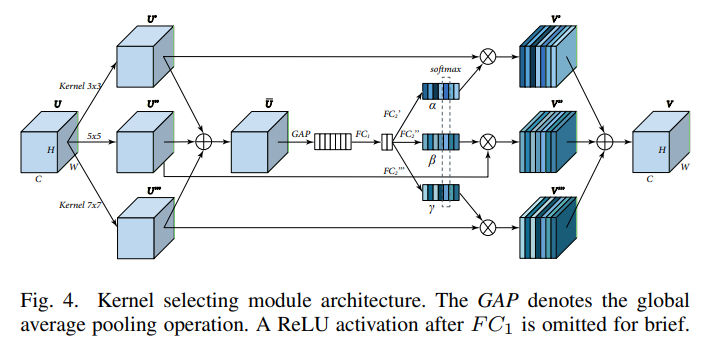

In [7]:
class Kernel_selecting_module(tf.keras.layers.Layer):
    def __init__(self, C=21, **kwargs):
        super().__init__(**kwargs)
        self.C = C
        self.c_3 = Conv2D(filters=self.C, kernel_size=(3,3), strides=1, padding='same', kernel_regularizer=regularizers.l2(l2=0.001))
        self.c_5 = Conv2D(filters=self.C, kernel_size=(5,5), strides=1, padding='same', kernel_regularizer=regularizers.l2(l2=0.001))
        self.c_7 = Conv2D(filters=self.C, kernel_size=(7,7), strides=1, padding='same', kernel_regularizer=regularizers.l2(l2=0.001))
        self.gap = GlobalAveragePooling2D()
        self.dense_two = Dense(units=2, activation='relu')
        self.dense_c1 = Dense(units=self.C)
        self.dense_c2 = Dense(units=self.C)
        self.dense_c3 = Dense(units=self.C)
    
    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'C': self.C
        })
        return config

    def call(self, X):
        X_1 = self.c_3(X)
        X_2 = self.c_5(X)
        X_3 = self.c_7(X)

        X_dash = Add()([X_1, X_2, X_3])

        v_gap = self.gap(X_dash)
        v_gap = tf.reshape(v_gap, [-1, 1, 1, self.C])
        fc1 = self.dense_two(v_gap)

        alpha = self.dense_c1(fc1)
        beta = self.dense_c2(fc1)
        gamma = self.dense_c3(fc1)

        before_softmax = concatenate([alpha, beta, gamma], 1)
        # print(before_softmax.shape)
        after_softmax = softmax(before_softmax, axis=1)
        a1 = after_softmax[:, 0, :, :]
        # print(a1)
        a1 = tf.reshape(a1, [-1, 1, 1, self.C])
        # print(a1)
        a2 = after_softmax[:, 1, :, :]
        a2 = tf.reshape(a2, [-1, 1, 1, self.C])
        a3 = after_softmax[:, 2, :, :]
        a3 = tf.reshape(a3, [-1, 1, 1, self.C])

        select_1 = Multiply()([X_1, a1])
        select_2 = Multiply()([X_2, a2])
        select_3 = Multiply()([X_3, a3])

        out = Add()([select_1, select_2, select_3])

        return out

In [8]:
def create_model():
    # ca_block = Channel Attention block
    # msfe_block = Multi scale feature extraction block
    # ksm = Kernel Selecting Module
    tf.keras.backend.clear_session()

    input = Input(shape=(256,256,3), name="input_layer")
    print("Input =",input.shape)

    conv_block = Convolutional_block()(input)
    print("Conv block =",conv_block.shape)
    ca_block = Channel_attention()(conv_block)
    print("Channel Attention =",ca_block.shape)
    ca_block = Conv2D(filters=3, kernel_size=(3,3), strides=1, padding='same')(ca_block)
    print("Channel Attention Last CNN =",ca_block.shape)
    ca_block = Concatenate()([input, ca_block])
    print("First phase =",ca_block.shape)
    print()

    msfe_block = Multi_scale_feature_extraction()(ca_block)

    print("Multi-scale feature extraction =",msfe_block.shape)

    ksm = Kernel_selecting_module()(msfe_block)
    ksm = Conv2D(filters=3, kernel_size=(3,3), strides=1, padding='same')(ksm)
    print("Kernel Selection Module =",ksm.shape)
    model = Model(inputs=[input], outputs=[ksm])
    

    
    return model

model = create_model()
model.summary()
model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=Adam(learning_rate=0.0009))

Input = (None, 256, 256, 3)
Conv block = (None, 256, 256, 64)
Channel Attention = (None, 256, 256, 64)
Channel Attention Last CNN = (None, 256, 256, 3)
First phase = (None, 256, 256, 6)

Multi-scale feature extraction = (None, 256, 256, 21)
Kernel Selection Module = (None, 256, 256, 3)
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_layer (InputLayer)       [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 convolutional_block (Convoluti  (None, 256, 256, 64  112576     ['input_layer[0][0]']            
 onal_block)                    )                                                                 
     

# **Inference**

In [10]:
# Inference
def inference_single_image(model, noisy_image):
    input_image = np.expand_dims(noisy_image, axis=0)
    predicted_image = model.predict(input_image)    
#     print(predicted_image.shape)
    
    
    return predicted_image[0]

In [11]:
def inference_batch_images(model, noisy_images):
    predicted_image = model.predict(noisy_images)
    return predicted_image

In [29]:
def visualize_predictions(model, X_test, y_test, n):
#     random_numbers = random.choices(range(X_test.shape[0]), k=n)    # Get n random indices
    images_lst=[]
    noisy_lst=[]
    org_lst=[]
    for i in range(n):
        noisy_image = X_test[i]
        noisy_lst.append(noisy_image) #add
        
        gt_image = y_test[i]
        org_lst.append(gt_image) #add
        
        predicted_image = inference_single_image(model, X_test[i])
        predicted_image/=255
        images_lst.append(predicted_image) #add
        if i == 24:
            f, axarr = plt.subplots(1,3, figsize=(21,21))
            axarr[0].imshow(noisy_image)
            axarr[0].set_title("Noisy image")
            axarr[0].set_axis_off()
            axarr[1].imshow(gt_image)
            axarr[1].set_title("Original image")
            axarr[1].set_axis_off()
            axarr[2].imshow(predicted_image)
            axarr[2].set_title("Predicted image")
            axarr[2].set_axis_off()
    return org_lst, noisy_lst, images_lst  #add
    

# Load the Deep Learning model

In [13]:
# best_models_path = "/content/drive/MyDrive/Colab Notebooks/Applied AI Assignments/Case Study 2 Image Denoising/Best Models/PRIDNet model/"
# best_models_path = 'C:\\Pre_trained\\'
model = tf.keras.models.load_model('best_PRIDNet_blindnoise_256x256.h5', custom_objects={'Convolutional_block': Convolutional_block,
                                                                                                        'Channel_attention':Channel_attention,
                                                                                                        'Avg_pool_Unet_Upsample_msfe':Avg_pool_Unet_Upsample_msfe,
                                                                                                        'Multi_scale_feature_extraction':Multi_scale_feature_extraction,
                                                                                                        'Kernel_selecting_module':Kernel_selecting_module})

# Denoise the images using Deep Learning model

In [14]:
root = pathlib.Path('C:\\Pre_trained\\noisy10')
img_paths = list(root.rglob("*.png*"))
img_paths_lst = [str(path) for path in img_paths]

noisy_array = np.asarray(img_paths_lst)

root = pathlib.Path('C:\\Pre_trained\\original')
img_paths = list(root.rglob("*.png*"))
img_paths_lst = [str(path) for path in img_paths]

org_array = np.asarray(img_paths_lst)

In [15]:
def get_images_in_mem(images_paths):
    images_lst = []
    for img_path in tqdm(images_paths):
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (256, 256))
        images_lst.append(img)
    return np.array(images_lst)

In [16]:
noisy_images = get_images_in_mem(noisy_array)
org_images = get_images_in_mem(org_array)

print(noisy_images.shape)
print(org_images.shape)


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

(25, 256, 256, 3)
(25, 256, 256, 3)


# Denoise Noisy10 images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


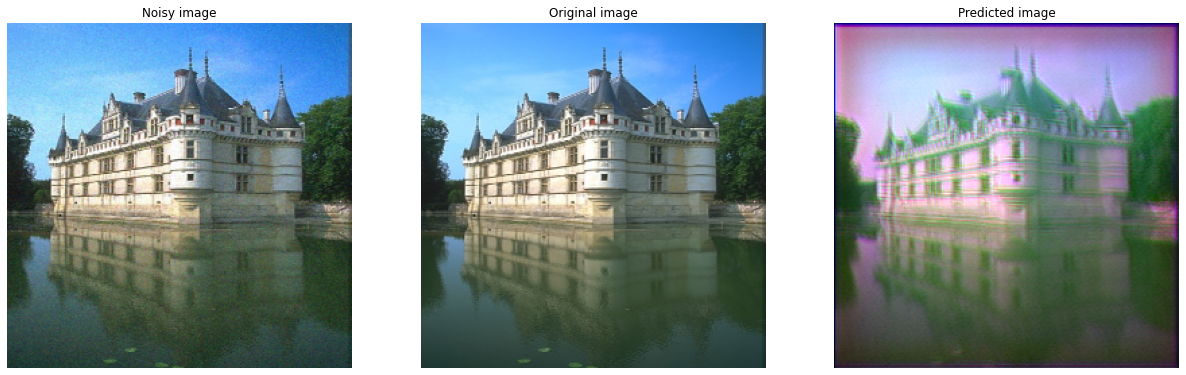

In [18]:
org_images, noisy_images, predicted_images = visualize_predictions(model, noisy_images, org_images, 25)

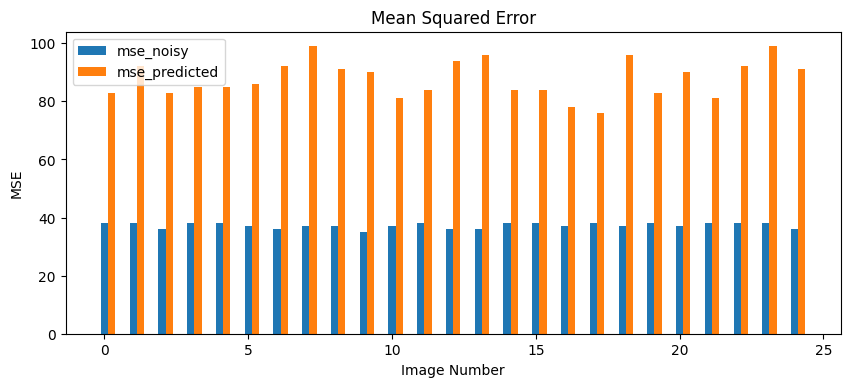

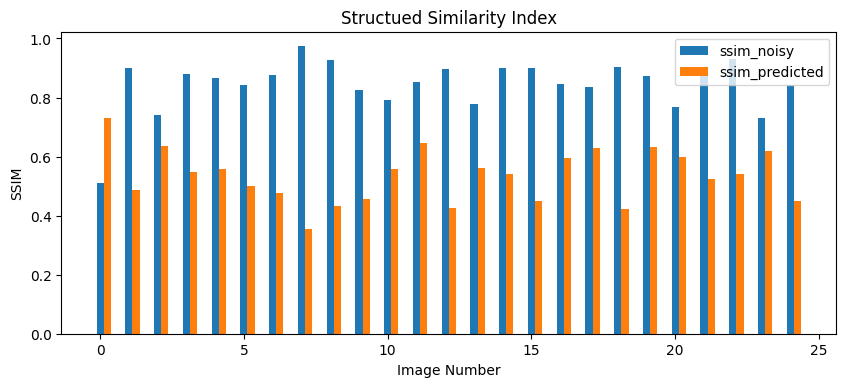

In [19]:
from skimage.metrics import structural_similarity as ssim
from matplotlib import pyplot as plt
from matplotlib import rcParams

# Adjust figure sizes
plt.rcParams['figure.figsize'] = [14, 10]
plt.rcParams['figure.dpi'] = 100 


ls_mse_noisy = []
ls_mse_predict = []
ls_ssim_noisy = []
ls_ssim_predict = []

for org_img, noisy_img, predicted_img in zip(org_images, noisy_images, predicted_images):

    predicted_img = (predicted_img*255).astype('uint8')

    mse_noisy = np.mean((org_img - noisy_img)**2).astype(np.uint8)
    ls_mse_noisy.append(mse_noisy)
    
    mse_pred  = np.mean((org_img - predicted_img)**2).astype(np.uint8)
    ls_mse_predict.append(mse_pred)

    ssim_noisy = ssim(org_img, noisy_img, multichannel=True, data_range=noisy_img.max() - noisy_img.min())
    ls_ssim_noisy.append(ssim_noisy)
    
    ssim_pred = ssim(org_img, predicted_img, multichannel=True, data_range=predicted_img.max() - predicted_img.min())
    ls_ssim_predict.append(ssim_pred)

    

#------------------------------------
# Plots
#------------------------------------
#Adjust figure sizes
rcParams['figure.figsize'] = [10, 4]
plt.rcParams['figure.dpi'] = 100
X_axis=np.arange(0,25)
X_axis1 = X_axis
X_axis2 = X_axis + 0.25

#------------------------------------------------------------
# Plot Mean Squared Error for each image
#------------------------------------------------------------
plt.bar(X_axis1, ls_mse_noisy, 0.25, label='mse_noisy')
plt.bar(X_axis2, ls_mse_predict, 0.25, label='mse_predicted')
plt.xlabel('Image Number')
plt.ylabel('MSE')
plt.title('Mean Squared Error')
plt.legend()
plt.show()

#------------------------------------------------------------
# Plot Structued Similarity Index for each image
#------------------------------------------------------------
plt.bar(X_axis1, ls_ssim_noisy, 0.25, label='ssim_noisy')
plt.bar(X_axis2, ls_ssim_predict, 0.25, label='ssim_predicted')
plt.xlabel('Image Number')
plt.ylabel('SSIM')
plt.title('Structued Similarity Index')
plt.legend()
plt.show()    


# Denoise Noisy25 images

In [20]:
#--------------------------------------------------
# Load Images Noisy25 
#--------------------------------------------------
#
root = pathlib.Path('C:\\Pre_trained\\noisy25')
img_paths = list(root.rglob("*.png*"))
img_paths_lst = [str(path) for path in img_paths]

noisy_array = np.asarray(img_paths_lst)

root = pathlib.Path('C:\\Pre_trained\\original')
img_paths = list(root.rglob("*.png*"))
img_paths_lst = [str(path) for path in img_paths]

org_array = np.asarray(img_paths_lst)

#-------------------------------------------------
# Resize the images and load into array
#-------------------------------------------------
#
def get_images_in_mem(images_paths):
    images_lst = []
    for img_path in tqdm(images_paths):
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (256, 256))
        images_lst.append(img)
    return np.array(images_lst)

# Load Images Noisy25 
noisy_images = get_images_in_mem(noisy_array)
org_images = get_images_in_mem(org_array)

print(noisy_images.shape)
print(org_images.shape)


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

(25, 256, 256, 3)
(25, 256, 256, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


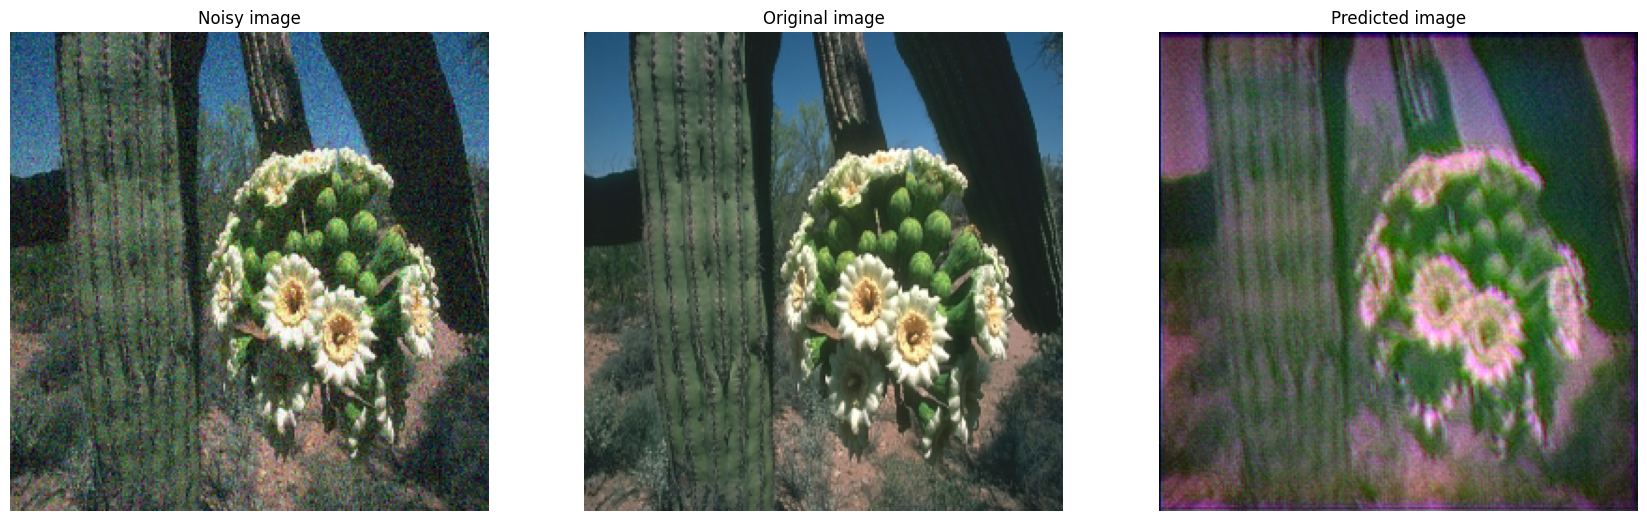

In [26]:
org_images, noisy_images25, predicted_images25 = visualize_predictions(model, noisy_images, org_images, 25)

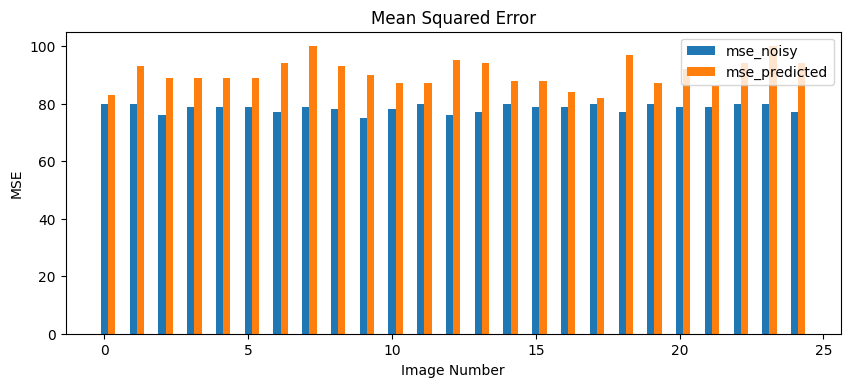

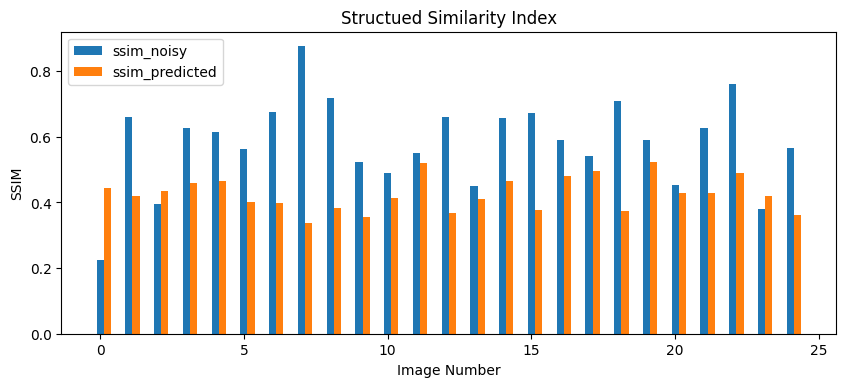

In [27]:
from skimage.metrics import structural_similarity as ssim
from matplotlib import pyplot as plt
from matplotlib import rcParams

# Adjust figure sizes
plt.rcParams['figure.figsize'] = [14, 10]
plt.rcParams['figure.dpi'] = 100 


ls_mse_noisy = []
ls_mse_predict = []
ls_ssim_noisy = []
ls_ssim_predict = []

#------------------------------------------------
# Calculate SME and SSIM for Noisy25 images
#------------------------------------------------
for org_img, noisy_img, predicted_img in zip(org_images, noisy_images25, predicted_images25):

    predicted_img = (predicted_img*255).astype('uint8')

    mse_noisy = np.mean((org_img - noisy_img)**2).astype(np.uint8)
    ls_mse_noisy.append(mse_noisy)
    
    mse_pred  = np.mean((org_img - predicted_img)**2).astype(np.uint8)
    ls_mse_predict.append(mse_pred)

    ssim_noisy = ssim(org_img, noisy_img, multichannel=True, data_range=noisy_img.max() - noisy_img.min())
    ls_ssim_noisy.append(ssim_noisy)
    
    ssim_pred = ssim(org_img, predicted_img, multichannel=True, data_range=predicted_img.max() - predicted_img.min())
    ls_ssim_predict.append(ssim_pred)

    

#------------------------------------
# Plots
#------------------------------------
#Adjust figure sizes
rcParams['figure.figsize'] = [10, 4]
plt.rcParams['figure.dpi'] = 100
X_axis=np.arange(0,25)
X_axis1 = X_axis
X_axis2 = X_axis + 0.25

#------------------------------------------------------------
# Plot Mean Squared Error for each image
#------------------------------------------------------------
plt.bar(X_axis1, ls_mse_noisy, 0.25, label='mse_noisy')
plt.bar(X_axis2, ls_mse_predict, 0.25, label='mse_predicted')
plt.xlabel('Image Number')
plt.ylabel('MSE')
plt.title('Mean Squared Error')
plt.legend()
plt.show()

#------------------------------------------------------------
# Plot Structued Similarity Index for each image
#------------------------------------------------------------
plt.bar(X_axis1, ls_ssim_noisy, 0.25, label='ssim_noisy')
plt.bar(X_axis2, ls_ssim_predict, 0.25, label='ssim_predicted')
plt.xlabel('Image Number')
plt.ylabel('SSIM')
plt.title('Structued Similarity Index')
plt.legend()
plt.show()    


# Denoise Noisy50 images

In [28]:
#--------------------------------------------------
# Load Images Noisy50 
#--------------------------------------------------
#
root = pathlib.Path('C:\\Pre_trained\\noisy50')
img_paths = list(root.rglob("*.png*"))
img_paths_lst = [str(path) for path in img_paths]

noisy_array = np.asarray(img_paths_lst)

root = pathlib.Path('C:\\Pre_trained\\original')
img_paths = list(root.rglob("*.png*"))
img_paths_lst = [str(path) for path in img_paths]

org_array = np.asarray(img_paths_lst)

#-------------------------------------------------
# Resize the images and load into array
#-------------------------------------------------
#
def get_images_in_mem(images_paths):
    images_lst = []
    for img_path in tqdm(images_paths):
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (256, 256))
        images_lst.append(img)
    return np.array(images_lst)

# Load Images Noisy50 
noisy_images = get_images_in_mem(noisy_array)
org_images = get_images_in_mem(org_array)

print(noisy_images.shape)
print(org_images.shape)

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

(25, 256, 256, 3)
(25, 256, 256, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


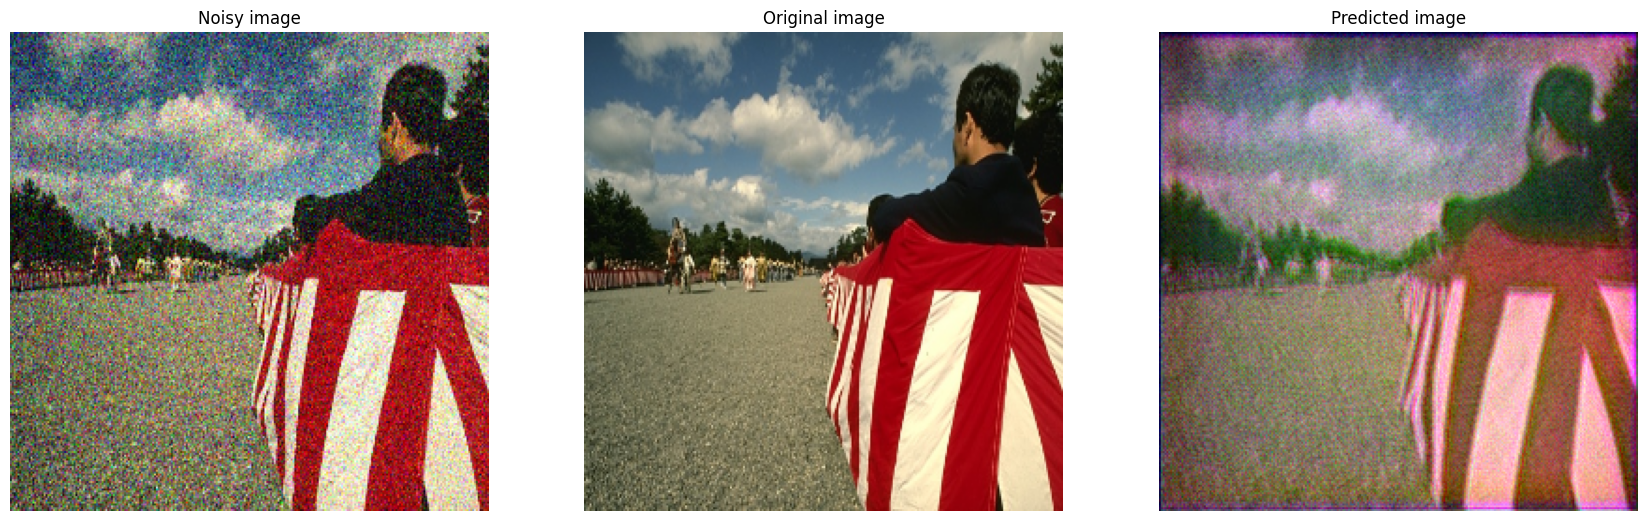

In [30]:
org_images, noisy_images50, predicted_images50 = visualize_predictions(model, noisy_images, org_images, 25)

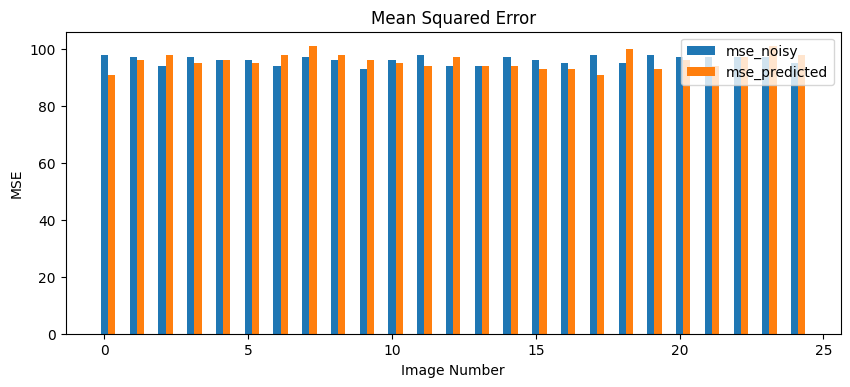

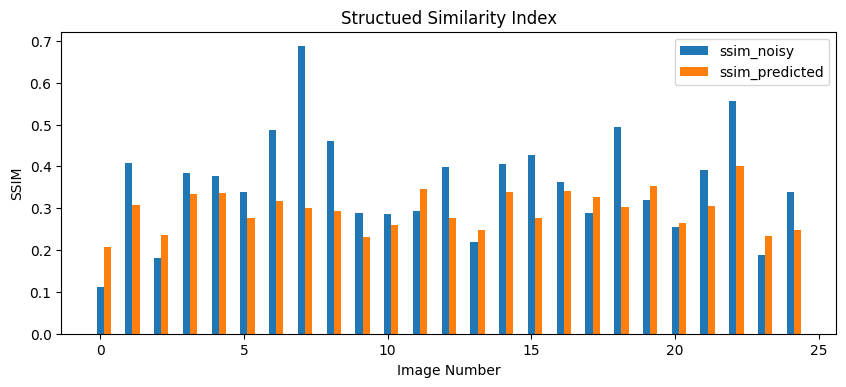

In [31]:
from skimage.metrics import structural_similarity as ssim
from matplotlib import pyplot as plt
from matplotlib import rcParams

# Adjust figure sizes
plt.rcParams['figure.figsize'] = [14, 10]
plt.rcParams['figure.dpi'] = 100 


ls_mse_noisy = []
ls_mse_predict = []
ls_ssim_noisy = []
ls_ssim_predict = []

#------------------------------------------------
# Calculate SME and SSIM for Noisy50 images
#------------------------------------------------
for org_img, noisy_img, predicted_img in zip(org_images, noisy_images50, predicted_images50):

    predicted_img = (predicted_img*255).astype('uint8')

    mse_noisy = np.mean((org_img - noisy_img)**2).astype(np.uint8)
    ls_mse_noisy.append(mse_noisy)
    
    mse_pred  = np.mean((org_img - predicted_img)**2).astype(np.uint8)
    ls_mse_predict.append(mse_pred)

    ssim_noisy = ssim(org_img, noisy_img, multichannel=True, data_range=noisy_img.max() - noisy_img.min())
    ls_ssim_noisy.append(ssim_noisy)
    
    ssim_pred = ssim(org_img, predicted_img, multichannel=True, data_range=predicted_img.max() - predicted_img.min())
    ls_ssim_predict.append(ssim_pred)

    

#------------------------------------
# Plots
#------------------------------------
#Adjust figure sizes
rcParams['figure.figsize'] = [10, 4]
plt.rcParams['figure.dpi'] = 100
X_axis=np.arange(0,25)
X_axis1 = X_axis
X_axis2 = X_axis + 0.25

#------------------------------------------------------------
# Plot Mean Squared Error for each image
#------------------------------------------------------------
plt.bar(X_axis1, ls_mse_noisy, 0.25, label='mse_noisy')
plt.bar(X_axis2, ls_mse_predict, 0.25, label='mse_predicted')
plt.xlabel('Image Number')
plt.ylabel('MSE')
plt.title('Mean Squared Error')
plt.legend()
plt.show()

#------------------------------------------------------------
# Plot Structued Similarity Index for each image
#------------------------------------------------------------
plt.bar(X_axis1, ls_ssim_noisy, 0.25, label='ssim_noisy')
plt.bar(X_axis2, ls_ssim_predict, 0.25, label='ssim_predicted')
plt.xlabel('Image Number')
plt.ylabel('SSIM')
plt.title('Structued Similarity Index')
plt.legend()
plt.show()    
